<h1>TWITTER SENTIMENT ANALYSIS WITH SNSCRAPE, TRANSFORMERS, AFINN AND LOGISTIC REGRESION</h1>

<h2>INTRODUCTION</h2>

Gabapentinoids are drugs that are derivatives of the inhibitory neurotransmitter gamma-Aminobutyric acid (GABA) (i.e., GABA analogues). Citing the FDA website: "Gabapentinoids are FDA-approved to treat a variety of conditions including partial seizures and nerve pain from spinal cord injury, shingles, and diabetes. Other approved uses include fibromyalgia and restless legs syndrome. Gabapentin was first approved in 1993 and pregabalin was first approved in 2004. Gabapentin is marketed under the brand names Neurontin and Gralise, and also as generics. Gabapentin enacarbil is marketed under the brand name Horizant. Pregabalin is marketed under the brand names Lyrica and Lyrica CR, and also as generics. Pregabalin is a Schedule V controlled substance, which means it has a lower potential for abuse among the drugs scheduled by the Drug Enforcement Administration (DEA), but may lead to some physical or psychological dependence."

Apart from the uses that are FDA-approved, gabapentinoids are widely prescribed for many off-label uses: all kinds of pain, bipolar disorder, anxiety, depression, insomnia, endometriosis, hot flushes... and are considered a safe alternative to opioids. They are also prescribed to pets. 

For many people, gabapentinoids are 'miracle drugs' and 'godsends'. For many people (including myself), they are ineffective and have many side effects and adverse reactions. That's the reason why I'm going to try to perform a sentiment analysis on tweets that mention these drugs.

<h2>DATA</h2>

<h3>Data Gathering</h3>

Code used to scrape tweets written in English that contain the term 'pregabalin' and to save it in a CSV file:

In [ ]:
#Importing necessary library
import snscrape.modules.twitter as sntwitter
import pandas as pd
import itertools

pd.set_option('display.max_columns', None)

pd.set_option('display.max_colwidth', None)

In [ ]:
#Importing the datetime to calculate the time for scraping the 50000 tweets
from datetime import datetime
start_time = datetime.now()

In [ ]:
#Creating dataframe called 'data' and storing the tweets 'Pregabalin' written in English.
data = pd.DataFrame(itertools.islice(sntwitter.TwitterSearchScraper(
    "pregabalin lang:en").get_items(), 50000))
end_time = datetime.now()

In [ ]:
data.to_csv('snspregabalin.csv')

I repeat the same process for 'gabapentin', 'gabapentinoids', 'neurontin', 'gralise' and 'horizant' and put together all the tweets.

In [2]:
import pandas as pd

csv_files = ['snsgabapentin.csv', 'snsgabapentinoids.csv', 'snspregabalin.csv', 'snsneurontin.csv', 'snsgralise.csv', 
             'snshorizant.csv']

tweets = []

for filename in csv_files:
    data = pd.read_csv(filename, encoding='utf-8', low_memory=False)
    tweets.append(data)
    
tweets = pd.concat(tweets)

tweets.shape

(132076, 28)

In [3]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132076 entries, 0 to 3453
Data columns (total 28 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        132076 non-null  int64  
 1   url               132076 non-null  object 
 2   date              132076 non-null  object 
 3   content           132076 non-null  object 
 4   renderedContent   132076 non-null  object 
 5   id                132076 non-null  int64  
 6   user              132076 non-null  object 
 7   replyCount        132076 non-null  int64  
 8   retweetCount      132076 non-null  int64  
 9   likeCount         132076 non-null  int64  
 10  quoteCount        132076 non-null  int64  
 11  conversationId    132076 non-null  int64  
 12  lang              132076 non-null  object 
 13  source            132076 non-null  object 
 14  sourceUrl         132076 non-null  object 
 15  sourceLabel       132076 non-null  object 
 16  outlinks          4530

I decide to keep only the next columns:

In [4]:
tweets = tweets[['date', 'content', 'id', 'replyCount',
       'retweetCount', 'likeCount', 'quoteCount', 'conversationId']]

tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132076 entries, 0 to 3453
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   date            132076 non-null  object
 1   content         132076 non-null  object
 2   id              132076 non-null  int64 
 3   replyCount      132076 non-null  int64 
 4   retweetCount    132076 non-null  int64 
 5   likeCount       132076 non-null  int64 
 6   quoteCount      132076 non-null  int64 
 7   conversationId  132076 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.1+ MB


In [5]:
tweets.drop_duplicates(subset='content', inplace=True)

tweets.shape

(122440, 8)

In [6]:
tweets.to_csv('snstweets.csv')

<h2>SENTIMENT ANALYSIS</h2>

<h3>Hugging Face Transformers</h3>

Code used to perform the analysis and add three more columns to the dataset:

In [ ]:
from transformers import pipeline
sentiment_classifier = pipeline('sentiment-analysis')

In [ ]:
df = pd.read_csv('snstweets.csv')

In [ ]:
df = (
    df
    .assign(sentiment = lambda x: x['content'].apply(lambda s: sentiment_classifier(s)))
    .assign(
         label = lambda x: x['sentiment'].apply(lambda s: (s[0]['label'])),
         score = lambda x: x['sentiment'].apply(lambda s: (s[0]['score']))
    )
)

In [ ]:
df.to_pickle('sentiment_tweets.pkl')

<h3>Afinn</h3>

Cleaning of mentions:

In [ ]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt

In [ ]:
df['content'] = np.vectorize(remove_pattern)(df['content'], "@[\w]*")

Removal of duplicates:

In [ ]:
df.drop_duplicates(subset='content', inplace=True)

Classification of tweets with Afinn

In [ ]:
from afinn import Afinn

afn = Afinn(emoticons=True)

scores = [afn.score(content) for content in df.content]

sentiment = ['positive' if score > 0 else 'negative' if score < 0 else 'neutral' for score in scores]
                          

df['af_scores'] = scores

df['af_sentiment'] = sentiment

In [ ]:
df.to_pickle("sentiment_tweets.pkl")

<h2>DATA CLEANING AND PREPROCESSING</h2>

First, we import all the necessary libraries.

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns # for visualization
import matplotlib.pyplot as plt # for visualization
from IPython.display import display

# for nlp
import nltk
import re
from nltk.stem import WordNetLemmatizer

# setting up the background style for the plots
plt.style.use('fivethirtyeight')
%matplotlib inline

pd.set_option("display.max_colwidth", 200) 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

This is the resulting dataset after applying Transformers and Afinn and removing mentions and duplicates.

In [2]:
df = pd.read_pickle('sentiment_tweets.pkl')

df.sample(5)

,date,content,id,replyCount,retweetCount,likeCount,quoteCount,conversationId,sentiment,label,score,af_scores,af_sentiment
47173,2019-07-08 23:38:12+00:00,A 25-Year-Old Drug For Nerve Pain Called Gabapentin Is Now Part Of The Opioid Crisis https://t.co/QN9GJzdWIv,1148375764892573696,0,0,0,0,1148375764892573696,"[{'label': 'NEGATIVE', 'score': 0.9986481070518494}]",NEGATIVE,0.998648,-5.0,negative
7756,2021-05-05 05:10:22+00:00,"I'm going off gabapentin and onto zonisamide for weight gain. Seems to be doing ok for the nerve pain. I'm down from 4 times a day to 2 or 3 times a day with ibuprofen &amp; Tylenol, and twice a...",1389809672719192066,0,0,1,0,1389789859045285891,"[{'label': 'POSITIVE', 'score': 0.9748300313949585}]",POSITIVE,0.974830,0.0,neutral
46025,2019-07-28 02:19:27+00:00,"Got it! From the vet, she was on rimadyl and gabapentin. Otc was aspirin (never acetaminophen!!). Also, glucosamine for old age joint pain (human version works). Also, pumpkin for soothing GI tract.",1155301712107855872,1,0,1,0,1155155278653874176,"[{'label': 'NEGATIVE', 'score': 0.9829466938972473}]",NEGATIVE,0.982947,1.0,positive
111114,2011-02-18 01:10:09+00:00,#viagra: Gabapentin 300 mg: Generic Neurontin - Viagra price per pill at http://gabapentin300mg.net/l/20211/vi9,38404870956531712,0,0,0,0,38404870956531712,"[{'label': 'NEGATIVE', 'score': 0.9966347217559814}]",NEGATIVE,0.996635,0.0,neutral
15670,2021-01-09 22:00:41+00:00,though these days i'm really glad it's mild enough that off-label gabapentin lets me get to sleep 😌,1348026936967135233,1,0,2,0,1348021495923003392,"[{'label': 'NEGATIVE', 'score': 0.9959456324577332}]",NEGATIVE,0.995946,3.0,positive


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122244 entries, 0 to 122439
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   date            122244 non-null  object 
 1   content         122244 non-null  object 
 2   id              122244 non-null  int64  
 3   replyCount      122244 non-null  int64  
 4   retweetCount    122244 non-null  int64  
 5   likeCount       122244 non-null  int64  
 6   quoteCount      122244 non-null  int64  
 7   conversationId  122244 non-null  int64  
 8   sentiment       122244 non-null  object 
 9   label           122244 non-null  object 
 10  score           122244 non-null  float64
 11  af_scores       122244 non-null  float64
 12  af_sentiment    122244 non-null  object 
dtypes: float64(2), int64(6), object(5)
memory usage: 13.1+ MB


In [5]:
df.shape

(122244, 13)

- Extraction of the lenghts of tweets for posterior analysis:

In [6]:
#Creating the length column for tweet
df['pre_clean_len']=  [len(t) for t in df.content]

- Change of 'date' column to datetime to setting as index of the dataset:

In [7]:
df['date'] = pd.to_datetime(df['date'])

df['date'].head()

0   2021-08-26 10:52:16+00:00
1   2021-08-26 09:28:24+00:00
2   2021-08-26 08:38:28+00:00
3   2021-08-26 07:45:22+00:00
4   2021-08-26 07:42:13+00:00
Name: date, dtype: datetime64[ns, UTC]

In [8]:
df = df.set_index('date')

df.sort_index(inplace=True)

df[['id', 'content']].sample(5)

,id,content
date,,
2013-08-12 21:30:23+00:00,367035359651053568,Neurontin Antitrust: NEWARK - Neither retailers like CVS nor drugmakers like Pfizer deserve summary judgm... http://t.co/vDKEtsd0YR
2019-11-08 08:21:00+00:00,1192718651578863621,"Adverse events more likely with concurrent opioid and benzodiazepine use. Gabapentinoids obliterate the ""respiratory tolerance"" that builds up in patients on high dose opioids: leading to apnoea..."
2014-06-05 21:40:20+00:00,474667058970767360,thanks. i haven't tried an snri. could always do that if upping pregabalin doesn't work *non-pharmacist sigh*
2021-01-27 20:32:46+00:00,1354527794814976006,"Mouse study: #gabapentin prevents harmful structural changes in #spinalcord https://t.co/Uw7OuR2RG3 via \n\n""Autonomic dysfunction is a major problem for people living with a spinal cord injury.""..."
2012-04-09 16:40:50+00:00,189392439465877505,#pharma #med Pregab Ml: i am getting pregabalin but have just spoke to my doctor about repeat priscription and ... http://t.co/KYzAjvVi


- Lowercasing

In [9]:
df['clean_content'] = df['content'].str.lower()

- Keep only the tweets that contain the terms 'gabapentinoids', 'gabapentin', 'neurontin', 'lyrica', 'pregabalin', 'gralise', and 'horizant'.

In [10]:
df = df[df['clean_content'].str.contains('gabapentinoids|gabapentin|neurontin|lyrica|pregabalin|gralise|horizant')]

df.shape

(120486, 14)

- Extract hashtags for posterior analysis.

In [11]:
tag_list = []
def hashtag_extract(x):
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        tag_list.append(ht)
    return tag_list

In [12]:
hasht = hashtag_extract(df['clean_content'])

hasht = sum(hasht,[])

In [13]:
hashtags = nltk.FreqDist(hasht)
hashtags = pd.DataFrame({'Hashtag': list(hashtags.keys()),
                  'Count': list(hashtags.values())}).sort_values(by='Count', ascending=False)
hashtags.to_csv('hashtags.csv')

- For the preprocessing of URLs, emoticons, non-alphanumeric characters, consecutive letters, strings with just one alphanumeric character, stopwords and Lemmatization, we define a dictionary of emoticons and a set of stopwords and use a function.

In [14]:
# Defining dictionary of emoticons with their meanings.
emoticons = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set of stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and', 'amp', 'any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'but', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'gt', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'no', 'not', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 'quot', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 'URL', 'USER', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [15]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoticon in emoticons.keys():
            tweet = tweet.replace(emoticon, "EMOJI" + emoticons[emoticon])        
        # Replace all non alphanumerics.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            if word not in stopwordlist:
                if len(word)>1:
                    # Lemmatizing the word.
                    word = wordLemm.lemmatize(word)
                    tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

We transform the 'clean_content' column into a list and aplly the function:

In [16]:
df['clean_content'] = df['clean_content'].astype('str')

text = list(df['clean_content'])

text[:5]

["up till b's meds ~3:30am. already having exhaustion-linked auditory hallucinations & f*ed-up thinking...time for more neurontin.",
 'medinews: pregabalin decreases pain, expedites movement in knee replacement patients http://tinyurl.com/23aocu',
 '/fwump. how long is the damn neurontin supposed to take to work anyway? tired, grumpy, in pain. feh.',
 'appears that the neurontin is kicking in.  woo!  go go gadget no pain!',
 'oh boy, my first neurontin side effect: wooziness!  awesomesauce with fries.']

In [17]:
import time
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 23 seconds


In [18]:
df['clean_content'] = processedtext

df[['content', 'clean_content']].head(10)

,content,clean_content
date,,
2007-04-15 07:40:17+00:00,Up till B's meds ~3:30am. Already having exhaustion-linked auditory hallucinations & f*ed-up thinking...time for more Neurontin.,till med 30am already exhaustion linked auditory hallucination ed thinking time neurontin
2007-10-15 12:34:14+00:00,"medinews: Pregabalin Decreases Pain, Expedites Movement In Knee Replacement Patients http://tinyurl.com/23aocu",medinews pregabalin decrease pain expedites movement knee replacement patient
2007-10-30 23:33:59+00:00,"/fwump. how long is the damn neurontin supposed to take to work anyway? tired, grumpy, in pain. feh.",fwump long damn neurontin supposed take work anyway tired grumpy pain feh
2007-11-12 17:32:53+00:00,appears that the neurontin is kicking in. woo! go go gadget no pain!,appears neurontin kicking woo go go gadget pain
2007-11-20 21:01:09+00:00,"oh boy, my first neurontin side effect: wooziness! awesomesauce with fries.",oh boy first neurontin side effect wooziness awesomesauce fry
2007-12-28 23:04:18+00:00,"joints aching. nts: never, ever skip neurontin EVAR. ow. fuck.",joint aching nt never ever skip neurontin evar ow fuck
2008-01-15 16:20:06+00:00,"morning: feel kind of spacey, but not too bad. maybe some of the weird headspaces I've been in were neurontin? possible...",morning feel kind spacey bad maybe weird headspace neurontin possible
2008-01-15 17:57:23+00:00,"whee, neurontin fog + vague stumbling! ROCK ON! I &lt;3 side effects. /eyeroll off to the bank.",whee neurontin fog vague stumbling rock lt side effect eyeroll off bank
2008-01-15 18:25:22+00:00,"Whee, neurontin=dizzy & handshakes! Fun?",whee neurontin dizzy handshake fun


<h2>EDA</h2>

First, we extract the lenght of the clean tweets.

In [19]:
df['clean_len'] = [len(t) for t in df['clean_content']]

- Length of the tweets before and after cleaning:

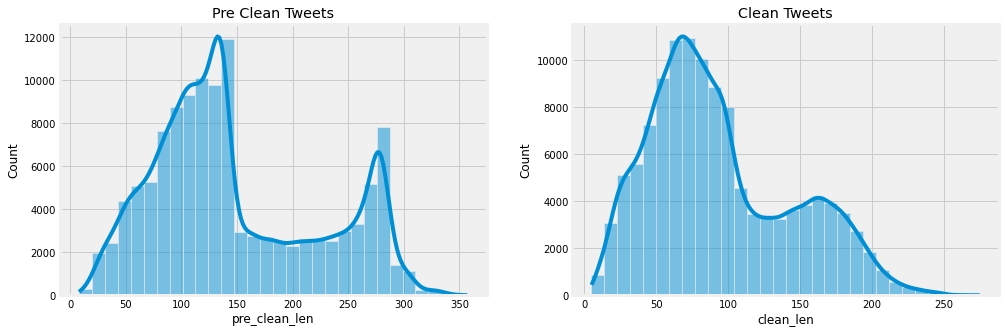

In [20]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
sns.histplot(df["pre_clean_len"],bins = 30,ax = ax1, kde=True).set(title = "Pre Clean Tweets")
sns.histplot(df["clean_len"],bins = 30,ax = ax2, kde = True).set(title = "Clean Tweets")
plt.show()

- Yearly boxplots:

<AxesSubplot:xlabel='date', ylabel='pre_clean_len'>

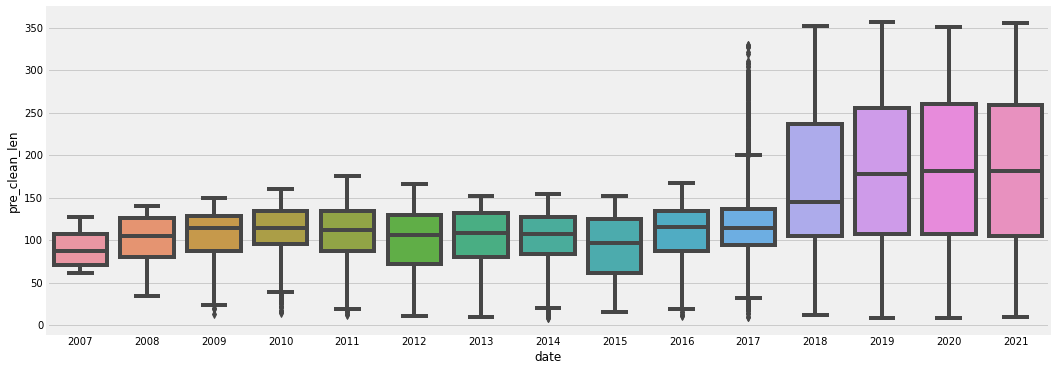

In [21]:
plt.figure(figsize=(16, 6))

# boxplots by month
sns.boxplot(x = df.index.year, y='pre_clean_len', data = df)

- Yearly distribution of tweets:

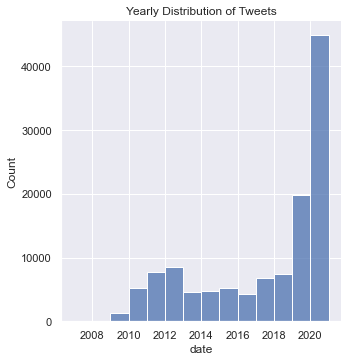

In [22]:
# Set the seaborn style
sns.set()
# Plot the histogram of hours
sns.displot(df.index.year, bins=14)
plt.title("Yearly Distribution of Tweets")
plt.show()

- Tweets with more likes:

In [23]:
display(df.sort_values(by=["likeCount"], axis=0, ascending=False)[["content", 'clean_content', "likeCount"]].head(10))

,content,clean_content,likeCount
date,,,
2021-03-03 20:49:52+00:00,only the baddest bitches take gabapentin💯 https://t.co/FJQXL2DUm3,baddest bitch take gabapentin,17045
2021-08-21 10:55:02+00:00,"Eleven weeks post-chemo, and, thanks to pregabalin, this is the first day I've been free of neuropathic pain, and the first night I haven't needed codeine to get to sleep. Celebrating with a nice ...",eleven week post chemo thanks pregabalin first day free neuropathic pain first night haven needed codeine get sleep celebrating nice cup tea maybe marmalade sandwich goodbyemrc,7730
2021-01-28 18:10:53+00:00,"grandson piss &gt; xanax, gabapentin https://t.co/svv3X5U1qH",grandson piss xanax gabapentin,3636
2020-09-25 15:54:15+00:00,"Hey friends.\nSo little change or movement since yesterday.\nStarted on Gabapentin for the week and ordered to rest for a few days.\nGood news I think is, its not my leg, but my paw which has swol...",hey friend little change movement since yesterday started gabapentin week ordered rest day good news think leg paw swollen day milking sympathy ordered dogsoftwitter dog dog,1878
2020-08-05 14:51:22+00:00,Which drug do you think has the most off-label use and why did you pick gabapentin?,drug think off label use pick gabapentin,1529
2021-01-10 05:10:50+00:00,I’m annoyed as fuck I tried to do something funny on fb that actually mirrored my life. Bitches... I’m on fucking Xanax I’m on gabapentin I now take 20 mg of Lexapro every morning I’m struggling...,annoyed fuck tried something funny fb actually mirrored life bitch fucking xanax gabapentin take 20 mg lexapro every morning struggling also trying keep humorous suck dick peace,1384
2021-07-11 18:05:46+00:00,"I love seeing him fast asleep. He doesn’t sleep much, so when he has his gabapentin I know he’s in no pain and he’s getting the rest he desperately needs. \n\nLittle Edward ❤️🥺❤️ https://t.co/IF50...",love seeing fast asleep doesn sleep much gabapentin know pain getting rest desperately need little edward,1198
2020-02-28 16:27:47+00:00,"I’d big pink star earrings on last night. Prob not policy. Saw a 20yo girl with seizure, heroin &amp; pregabalin abuse. Had refused all obs and access. She liked my earrings, I liked her pink hai...",big pink star earring last night prob policy saw 20yo girl seizure heroin pregabalin abuse refused ob access liked earring liked pink hair chat let treat patient diverse staff,1173
2020-09-02 01:25:19+00:00,"1/\nHOW does gabapentin work?\nDOES gabapentin work? \nWHY is gabapentin so shady?\n\nJoin me for a #tweetorial?\n\nKeywords: Glutatmate, Asterixis, Alcohol-use disorder\n#livertwitter #MedTwitter...",gabapentin work gabapentin work gabapentin shady join tweetorial keywords glutatmate asterixis alcohol use disorder livertwitter medtwitter meded,1017


- Tweets with more retweets:

In [24]:
display(df.sort_values(by=["retweetCount"], axis=0, ascending=False)[["content","retweetCount", "id"]].head(10))

,content,retweetCount,id
date,,,
2017-03-21 06:51:37+00:00,Buy Pregabalin (75 to 300 mg pills) or Lyrica Online from a UK Online Doctor Service Now More at https://t.co/tbQ6gbE1Sp,419,844079029313396736
2020-09-02 01:25:19+00:00,"1/\nHOW does gabapentin work?\nDOES gabapentin work? \nWHY is gabapentin so shady?\n\nJoin me for a #tweetorial?\n\nKeywords: Glutatmate, Asterixis, Alcohol-use disorder\n#livertwitter #MedTwitter...",343,1300968010124009472
2019-10-31 20:32:25+00:00,"Medicine is broken\n\n""Parke-Davis hired medical education companies to write review papers, original articles, and letters to the editor in medical journals about gabapentin for '$13,375 to $18,0...",303,1190003614577770497
2021-03-03 20:49:52+00:00,only the baddest bitches take gabapentin💯 https://t.co/FJQXL2DUm3,301,1367215672904863747
2021-07-22 08:23:40+00:00,⚡️Drugs used to treat Neuropathic Pain⚡️\n\n🔹pregabalin\n\n🔹gabapentin\n\n🔹duloxetine\n\n🔹amitriptyline\n\n🔹nortriptyline\n\n🔹carbamazepine,218,1418124571971051527
2021-01-28 18:10:53+00:00,"grandson piss &gt; xanax, gabapentin https://t.co/svv3X5U1qH",210,1354854474288783364
2020-04-29 08:19:03+00:00,"Preglabin and gabapentin are not effective for LBP, sciatica, spinal stenosis or episodic migraine - new SR https://t.co/PAPERZfyjP",177,1255411259740217346
2019-12-19 19:00:12+00:00,-- Pregabalin\n\nIndications: \n\n- Epilepsy\n- Neuropathic pain\n- Fibromyalgia\n\nMechanism: \n\nAn inhibitor of α2δ subunit-containing voltage-dependent calcium channels. \n\nThough it is a GAB...,171,1207737411033292800
2021-03-23 08:46:00+00:00,💊Drugs used to treat Neuropathic Pain\n\n🔸Amitriptyline\n\n🔸Duloxetine\n\n🔸Gabapentin\n\n🔸Pregabalin,165,1374281261414486017


In [25]:
df[df['id']==1190003614577770497]['content'].to_list()

['Medicine is broken\n\n"Parke-Davis hired medical education companies to write review papers, original articles, and letters to the editor in medical journals about gabapentin for \'$13,375 to $18,000 per article,\' plus a $1,000 honorarium for the author."\n\nhttps://t.co/MeIoaYIjlL']

- Tweets with more replies:

In [26]:
display(df.sort_values(by=["replyCount"], axis=0, ascending=False)[["content","replyCount", "id"]].head(10))

,content,replyCount,id
date,,,
2021-02-19 15:14:02+00:00,Any one have any strong feelings about the drug Gabapentin?,1538,1362782500964102150
2021-01-10 05:10:50+00:00,I’m annoyed as fuck I tried to do something funny on fb that actually mirrored my life. Bitches... I’m on fucking Xanax I’m on gabapentin I now take 20 mg of Lexapro every morning I’m struggling...,368,1348135189554155520
2020-09-25 15:54:15+00:00,"Hey friends.\nSo little change or movement since yesterday.\nStarted on Gabapentin for the week and ordered to rest for a few days.\nGood news I think is, its not my leg, but my paw which has swol...",218,1309521607640182785
2019-07-16 09:54:48+00:00,"I’m at the vets .. my neck is so painful I’m crying out every time I move ... good news I’ve lost lots of weight now only .. yes only 16.4 .. Vet given metacam, gabapentin and Pardale V. \nEnjoy y...",193,1151067651625684993
2021-08-21 10:55:02+00:00,"Eleven weeks post-chemo, and, thanks to pregabalin, this is the first day I've been free of neuropathic pain, and the first night I haven't needed codeine to get to sleep. Celebrating with a nice ...",183,1429034300519981063
2021-02-20 12:18:27+00:00,"I really don't know why I have to bring this up, but my Gabapentin usage is for seizure prevention.\n\nDon't cop an attitude about a medication that's saving my life right now.\n\nAlready had to b...",173,1363100703774793729
2020-08-05 14:51:22+00:00,Which drug do you think has the most off-label use and why did you pick gabapentin?,147,1291024000857014273
2019-07-19 20:34:29+00:00,Just met with the anesthesiologist prior to my surgery next week. He said Tylenol and gabapentin would be used for pain control.\nNo one is cutting me open and giving me freaking Tylenol for pain...,144,1152315797185822721
2020-06-10 09:03:23+00:00,"Dr thinks I have sciatica, but slightly untypical symptoms. Huge pain under right bum, just off to the right. Sitting /pressure; crippling pain down to knee. If I’ve been sitting, getting up very ...",135,1270642709041164288


- Unigrams:

In [27]:
text = ''.join(clean_content for clean_content in df.clean_content)

words = text.split()

In [28]:
unigrams = (pd.Series(nltk.ngrams(words, 1)).value_counts())[:20]

unigrams

(gabapentin,)    60484
(neurontin,)     41941
(pregabalin,)    33398
(pain,)          29906
(drug,)          13156
(take,)          12064
(lyrica,)        11985
(help,)           8893
(like,)           8543
(get,)            7992
(day,)            7651
(effect,)         7559
(nerve,)          7512
(med,)            7449
(off,)            6644
(work,)           6459
(new,)            6455
(generic,)        6441
(also,)           5923
(side,)           5728
dtype: int64

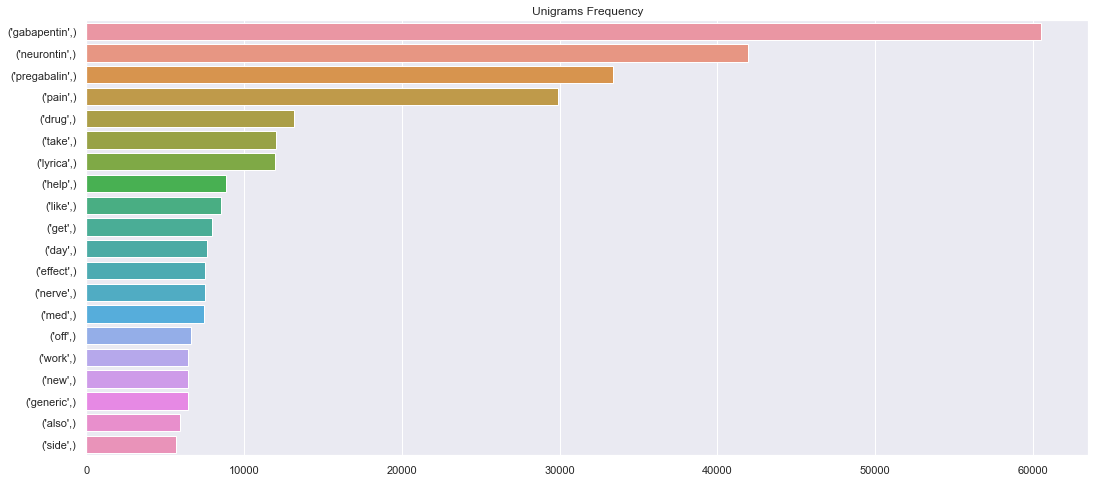

In [29]:
plt.figure(figsize=(16, 8))
sns.barplot(x=unigrams.values, y=unigrams.index)

plt.title('Unigrams Frequency')
plt.show()

- Bigrams:

In [30]:
bigrams = (pd.Series(nltk.ngrams(words, 2)).value_counts())[:19]

bigrams

(side, effect)              5058
(nerve, pain)               4508
(gabapentin, pregabalin)    3032
(neurontin, lyrica)         2698
(generic, neurontin)        2666
(lyrica, pregabalin)        2470
(neuropathic, pain)         2420
(take, gabapentin)          2386
(300, mg)                   2344
(mg, generic)               2122
(brain, synapsis)           2023
(death, sentence)           1984
(new, brain)                1977
(gabapentin, 300)           1971
(lyrica, death)             1934
(sentence, new)             1934
(pregabalin, gabapentin)    1804
(gabapentin, neurontin)     1541
(pregabalin, lyrica)        1532
dtype: int64

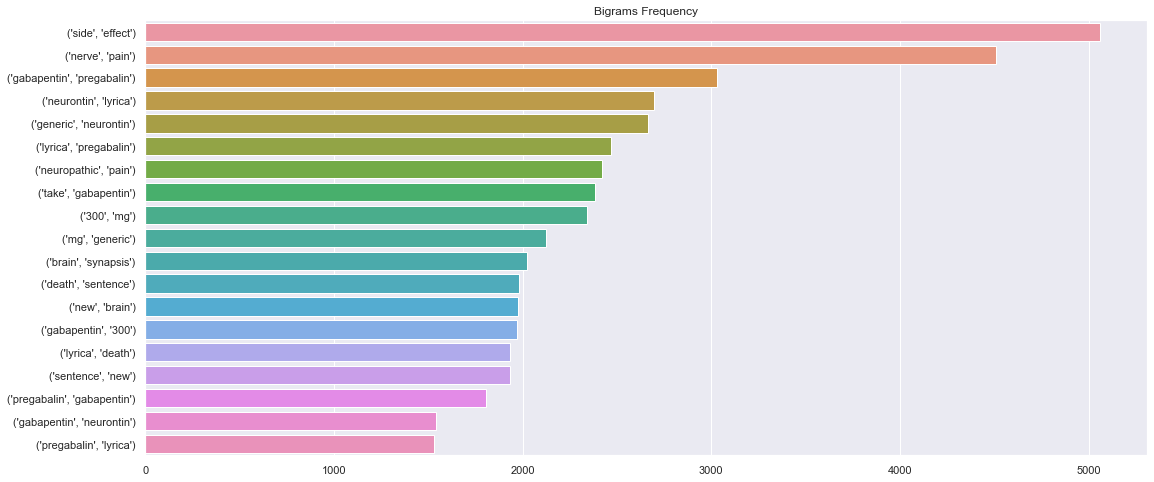

In [31]:
plt.figure(figsize=(16, 8))
sns.barplot(x=bigrams.values, y=bigrams.index)

plt.title('Bigrams Frequency')
plt.show()

- Trigrams

In [32]:
trigrams = (pd.Series(nltk.ngrams(words, 3)).value_counts())[:20]

trigrams

(new, brain, synapsis)               1962
(gabapentin, 300, mg)                1945
(death, sentence, new)               1934
(lyrica, death, sentence)            1931
(sentence, new, brain)               1930
(neurontin, lyrica, death)           1929
(300, mg, generic)                   1855
(mg, generic, neurontin)             1854
(neurontin, weight, loss)             830
(synapsis, shocking, study)           625
(brain, synapsis, shocking)           625
(restless, leg, syndrome)             602
(drug, gabapentin, pregabalin)        572
(gabapentin, pregabalin, linked)      504
(treatment, neuropathic, pain)        477
(lyrica, pregabalin, online)          471
(verdict, against, pfizer)            451
(gabapentin, nerve, pain)             437
(neurontin, neurontin, neurontin)     421
(neurontin, combined, cymbalta)       416
dtype: int64

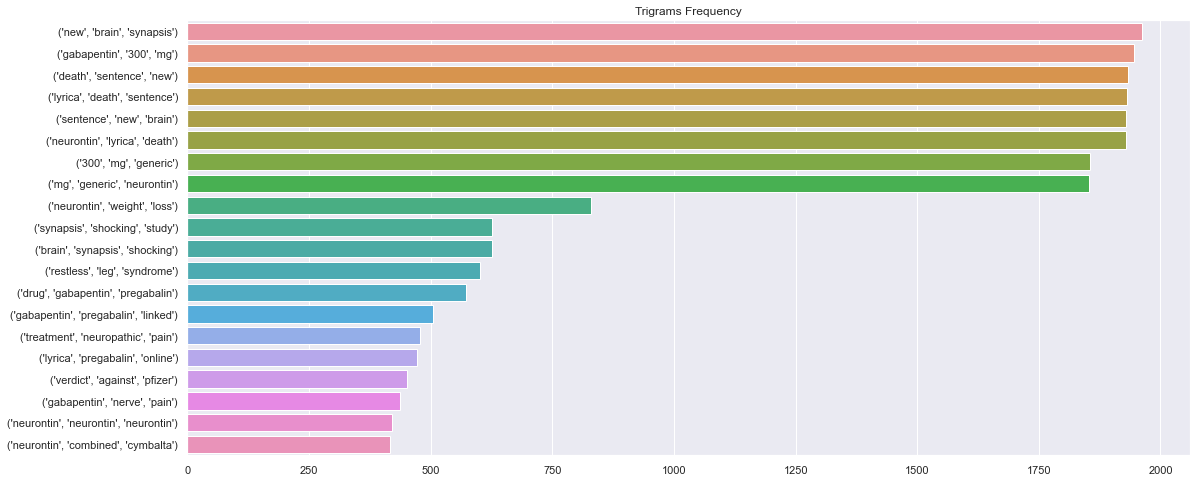

In [33]:
plt.figure(figsize=(16, 8))
sns.barplot(x=trigrams.values, y=trigrams.index)

plt.title('Trigrams Frequency')
plt.show()

- Hashtags Analysis:

In [34]:
hashtags = pd.read_csv('hashtags.csv')

hashtags = hashtags.drop(['Unnamed: 0'], axis = 1)

hashtags.head(20)

,Hashtag,Count
0,neurontin,4420
1,pregabalin,2334
2,gabapentin,1712
3,lyrica,734
4,chronicpain,683
5,fibromyalgia,647
6,pain,564
7,ebook,483
8,health,375
9,fibro,369


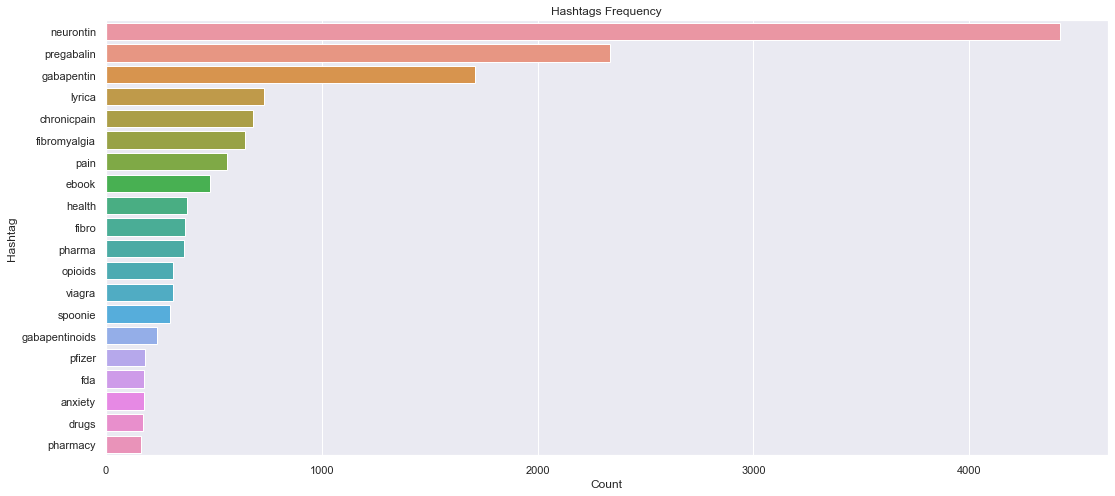

In [35]:
hashtags = hashtags.head(20)

plt.figure(figsize=(16, 8))
sns.barplot(x='Count', y='Hashtag', data=hashtags)

plt.title('Hashtags Frequency')
plt.show()

<h2>CLASSIFICATION OF TWEETS USING THE MODEL TRAINED IN THE SENTIMENT140 DATASET</h2>

We load the the vectoriser and the model and use a function to transform the processsed text and make predictions.

In [36]:
import pickle

file = open('vectoriser-ngram-(1,2).pickle', 'rb')
vectoriser = pickle.load(file)
file.close()

# Load the LR Model.
file = open('Sentiment-LR.pickle', 'rb')
LRmodel = pickle.load(file)
file.close()


In [37]:
def predict(vectoriser, model, text):
    # Predict the sentiment
    textdata = vectoriser.transform(text)
    sentiment = model.predict(textdata)
    return sentiment


In [38]:
lr_results = predict(vectoriser, LRmodel, processedtext)

lr_results

array([1, 0, 0, ..., 1, 0, 0])

We add the predictions to the dataset to compare the three methods:

In [39]:
df['lr_sentiment'] = lr_results

In [40]:
df.head()

,content,id,replyCount,retweetCount,likeCount,quoteCount,conversationId,sentiment,label,score,af_scores,af_sentiment,pre_clean_len,clean_content,clean_len,lr_sentiment
date,,,,,,,,,,,,,,,,
2007-04-15 07:40:17+00:00,Up till B's meds ~3:30am. Already having exhaustion-linked auditory hallucinations & f*ed-up thinking...time for more Neurontin.,28590161,0,0,0,0,28590161,"[{'label': 'NEGATIVE', 'score': 0.9958293437957764}]",NEGATIVE,0.995829,0.0,neutral,128,till med 30am already exhaustion linked auditory hallucination ed thinking time neurontin,90,1
2007-10-15 12:34:14+00:00,"medinews: Pregabalin Decreases Pain, Expedites Movement In Knee Replacement Patients http://tinyurl.com/23aocu",337148332,0,0,0,0,337148332,"[{'label': 'NEGATIVE', 'score': 0.9804479479789734}]",NEGATIVE,0.980448,-2.0,negative,110,medinews pregabalin decrease pain expedites movement knee replacement patient,78,0
2007-10-30 23:33:59+00:00,"/fwump. how long is the damn neurontin supposed to take to work anyway? tired, grumpy, in pain. feh.",376264212,0,0,0,0,376264212,"[{'label': 'NEGATIVE', 'score': 0.999584972858429}]",NEGATIVE,0.999585,-6.0,negative,100,fwump long damn neurontin supposed take work anyway tired grumpy pain feh,74,0
2007-11-12 17:32:53+00:00,appears that the neurontin is kicking in. woo! go go gadget no pain!,408691052,0,0,0,0,408691052,"[{'label': 'POSITIVE', 'score': 0.9734091758728027}]",POSITIVE,0.973409,0.0,neutral,70,appears neurontin kicking woo go go gadget pain,48,1
2007-11-20 21:01:09+00:00,"oh boy, my first neurontin side effect: wooziness! awesomesauce with fries.",430154292,0,0,0,0,430154292,"[{'label': 'POSITIVE', 'score': 0.8460352420806885}]",POSITIVE,0.846035,0.0,neutral,76,oh boy first neurontin side effect wooziness awesomesauce fry,62,1


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120486 entries, 2007-04-15 07:40:17+00:00 to 2021-08-28 01:45:15+00:00
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   content         120486 non-null  object 
 1   id              120486 non-null  int64  
 2   replyCount      120486 non-null  int64  
 3   retweetCount    120486 non-null  int64  
 4   likeCount       120486 non-null  int64  
 5   quoteCount      120486 non-null  int64  
 6   conversationId  120486 non-null  int64  
 7   sentiment       120486 non-null  object 
 8   label           120486 non-null  object 
 9   score           120486 non-null  float64
 10  af_scores       120486 non-null  float64
 11  af_sentiment    120486 non-null  object 
 12  pre_clean_len   120486 non-null  int64  
 13  clean_content   120486 non-null  object 
 14  clean_len       120486 non-null  int64  
 15  lr_sentiment    120486 non-null  int32  
dtypes: float64

In [42]:
df['label'] = df['label'].str.lower()

df = df.replace([0,1], ["negative","positive"])

df[['content', 'label', 'af_sentiment', 'lr_sentiment']].head(10)

,content,label,af_sentiment,lr_sentiment
date,,,,
2007-04-15 07:40:17+00:00,Up till B's meds ~3:30am. Already having exhaustion-linked auditory hallucinations & f*ed-up thinking...time for more Neurontin.,negative,neutral,positive
2007-10-15 12:34:14+00:00,"medinews: Pregabalin Decreases Pain, Expedites Movement In Knee Replacement Patients http://tinyurl.com/23aocu",negative,negative,negative
2007-10-30 23:33:59+00:00,"/fwump. how long is the damn neurontin supposed to take to work anyway? tired, grumpy, in pain. feh.",negative,negative,negative
2007-11-12 17:32:53+00:00,appears that the neurontin is kicking in. woo! go go gadget no pain!,positive,neutral,positive
2007-11-20 21:01:09+00:00,"oh boy, my first neurontin side effect: wooziness! awesomesauce with fries.",positive,neutral,positive
2007-12-28 23:04:18+00:00,"joints aching. nts: never, ever skip neurontin EVAR. ow. fuck.",negative,negative,negative
2008-01-15 16:20:06+00:00,"morning: feel kind of spacey, but not too bad. maybe some of the weird headspaces I've been in were neurontin? possible...",negative,negative,negative
2008-01-15 17:57:23+00:00,"whee, neurontin fog + vague stumbling! ROCK ON! I &lt;3 side effects. /eyeroll off to the bank.",negative,negative,positive
2008-01-15 18:25:22+00:00,"Whee, neurontin=dizzy & handshakes! Fun?",positive,positive,positive


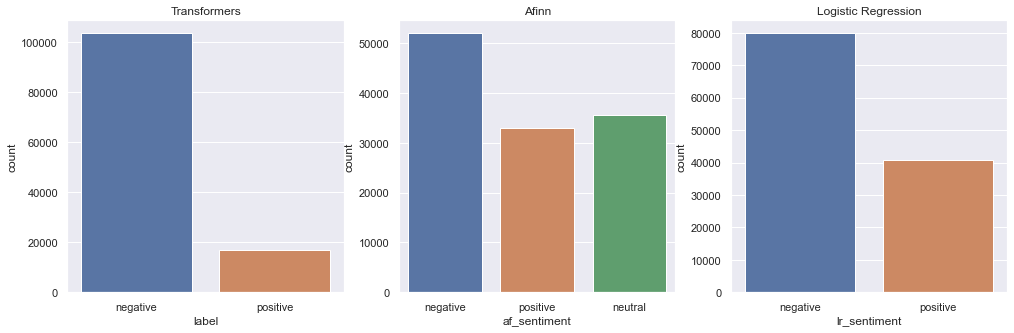

In [43]:
fig,(ax1,ax2, ax3)=plt.subplots(1,3,figsize=(15,5))
sns.countplot(x=df["label"],ax = ax1).set(title = "Transformers")
sns.countplot(x=df["af_sentiment"], order=['negative', 'positive', 'neutral'],ax = ax2).set(title = "Afinn")
sns.countplot(x=df["lr_sentiment"],order=['negative', 'positive'],ax = ax3).set(title = "Logistic Regression")
plt.show()

In [44]:
def consensus(row):
    count = 0
    count += row['label']==row['af_sentiment']
    count += row['label']==row['lr_sentiment']
    count += row['af_sentiment']==row['lr_sentiment']

    return count

df['consensus'] = df.apply(lambda row: consensus(row), axis=1)

df['consensus'].value_counts()

1    58348
3    46333
0    15805
Name: consensus, dtype: int64

In [45]:
all_three = df[df['consensus'] == 3]

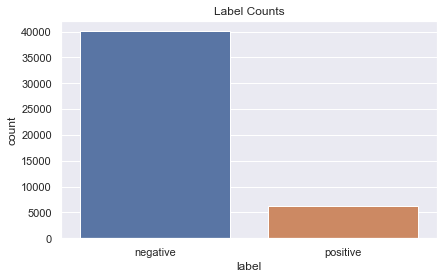

In [46]:
sns.countplot(x=all_three["label"])
plt.title("Label Counts")
plt.show()